In [1]:
# Core Dependencies
!pip install einops
!pip install vocos
!pip install torch torchvision torchaudio # Usually pre-installed in Colab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 36.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for encodec: filename=encodec-0.1.1-py3-none-any.whl size=45759 sha256=233d69d76b30751b9b21256af7b75e57f58bb06937bd45d4bb17e8ba60c2a472
  Stored in directory: /root/.cache/pip/wheels/b8/eb/9f/e13610cc46ab39d3199fbabebd1c3e142d44b679526e0f228a
Successfully built encodec


In [2]:
!pip install matplotlib numpy torchaudio
# You already installed einops and vocos in the previous step

##Spectrogram

In [ ]:
import torch
from torch.nn import Module
import torchaudio
import torchaudio.transforms as T
from torchaudio.functional import DB_to_amplitude
from einops import rearrange
from vocos import Vocos
import matplotlib.pyplot as plt
import numpy as np

# --- Helper Functions and Base Class ---

def exists(val):
    return exists is not None

class AudioEncoderDecoder(Module):
    pass

# --- Your Modified MelVoco Class ---

class SpecVoco(AudioEncoderDecoder):
    def __init__(
        self,
        *,
        log = True,
        sampling_rate = 24000,
        n_fft = 1024,
        win_length = 640,
        hop_length = 160,
        pretrained_vocos_path = 'charactr/vocos-mel-24khz'
    ):
        super().__init__()
        self.log = log
        self.n_fft = n_fft
        self.win_length = win_length
        self.hop_length = hop_length
        self.sampling_rate = sampling_rate

        self.vocos = Vocos.from_pretrained(pretrained_vocos_path)

    @property
    def downsample_factor(self):
        return self.hop_length

    @property
    def latent_dim(self):
        # Number of frequency bins: n_fft // 2 + 1
        return self.n_fft // 2 + 1

    def encode(self, audio):
        stft_transform = T.Spectrogram(
            n_fft = self.n_fft,
            win_length = self.win_length,
            hop_length = self.hop_length,
            window_fn = torch.hann_window,
            power=2.0 # Ensure the output is a power spectrogram
        )

        spectrogram = stft_transform(audio)

        # Explicitly remove the channel dimension
        spectrogram = spectrogram.reshape(spectrogram.shape[0], spectrogram.shape[2], spectrogram.shape[3])

        if self.log:
            # Apply log conversion (AmplitudeToDB) directly to the raw spectrogram
            # AmplitudeToDB expects a power spectrogram when converting to DB
            spectrogram = T.AmplitudeToDB()(spectrogram)

        # Reshape from (B, Freq, Time) to (B, Time, Freq/Dim)
        spectrogram = rearrange(spectrogram, 'b d n -> b n d')
        return spectrogram

    def decode(self, spectrogram_features):
        # Decode method is not needed for visualization, but kept for completeness
        spectrogram_features = rearrange(spectrogram_features, 'b n d -> b d n')
        # ... (rest of decode logic)
        return spectrogram_features # Returning features just for consistency, not actual audio

# --- Example Usage ---

# 1. Instantiate the model
model = SpecVoco(sampling_rate=16000) # Use 16kHz for common speech audio

# 2. Load a sample audio file
# IMPORTANT: Replace 'path/to/your/audio.wav' with a path to an audio file you upload or download.
# For example, you can upload a file and use its path.
try:
    # Attempt to load a sample audio file. Torchaudio loads (waveform, sample_rate).
    # We take the first channel if it's stereo, and ensure it's a 2D tensor (Batch, Time).
    waveform, sr = torchaudio.load('/content/out.wav')
    if sr != model.sampling_rate:
         # Resample the audio if the sample rate doesn't match the model's expected rate (recommended)
         resampler = T.Resample(sr, model.sampling_rate)
         waveform = resampler(waveform)

    # Use the first channel and add a batch dimension (1, Time)
    audio_input = waveform[:1, :].unsqueeze(0)

except FileNotFoundError:
    print("WARNING: Audio file not found. Generating dummy noise for visualization.")
    # Create 3 seconds of dummy noise if file loading fails
    T = model.sampling_rate * 3
    audio_input = torch.randn(1, 1, T)

# 3. Encode to get the Spectrogram features
# Output shape: (Batch, Time, Freq)
spectrogram_features = model.encode(audio_input)
print(f"\nEncoded Spectrogram Shape (B, T, Freq): {spectrogram_features.shape}")

# 4. Prepare data for plotting
# Convert to NumPy and remove the batch dimension.
# We transpose to (Freq, Time) for the plot, which is the standard format for visualization.
spectrogram_to_plot = spectrogram_features[0].cpu().numpy().T


Encoded Spectrogram Shape (B, T, Freq): torch.Size([1, 232, 513])


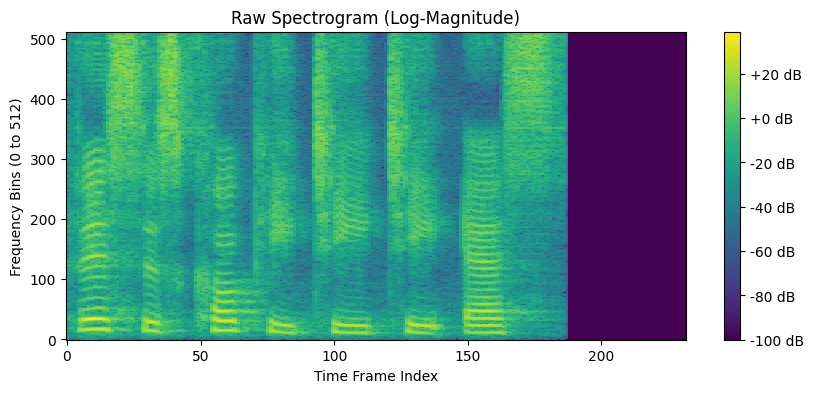

In [ ]:
# Create the plot
plt.figure(figsize=(10, 4))
plt.imshow(spectrogram_to_plot, aspect='auto', origin='lower',
           interpolation='none', cmap='viridis')

# Set labels for verification
# X-axis: Time (in frames)
plt.xlabel("Time Frame Index")
# Y-axis: Frequency Bins
# Since Freq Bins = n_fft/2 + 1, this confirms the output is a raw spectrogram
plt.ylabel(f"Frequency Bins (0 to {model.latent_dim - 1})")
plt.title("Raw Spectrogram (Log-Magnitude)")
plt.colorbar(format="%+2.0f dB")
plt.show()

In [10]:
import torch
from torch import nn
from torch.nn import Module
from einops import rearrange
import torchaudio
import torchaudio.transforms as T
from torchaudio.functional import DB_to_amplitude, resample
from vocos import Vocos
import numpy as np
import math

# --- UTILITIES ---
def exists(val): return val is not None
def default(val, d): return val if exists(val) else default

class AudioEncoderDecoder(nn.Module): pass

# --- MODIFIED SPEC VOCO (with CORRECTED Decode logic) ---

class SpecVoco(AudioEncoderDecoder):
    def __init__(self, *, log = True, sampling_rate = 24000, n_fft = 1024, win_length = 640, hop_length = 160, f_max = 8000, n_mels=100, **kwargs):
        super().__init__()
        self.log = log
        self.n_fft = n_fft
        self.win_length = win_length
        self.hop_length = hop_length
        self.sampling_rate = sampling_rate
        self.f_max = f_max
        self.n_mels = n_mels
        self.vocos = Vocos.from_pretrained('charactr/vocos-mel-24khz')

    @property
    def downsample_factor(self): return self.hop_length
    @property
    def latent_dim(self): return self.n_fft // 2 + 1

    def encode(self, audio):
        stft_transform = T.Spectrogram(n_fft=self.n_fft, win_length=self.win_length, hop_length=self.hop_length, window_fn=torch.hann_window, power=2.0)
        spectrogram = stft_transform(audio)
        if spectrogram.ndim == 4: spectrogram = spectrogram.squeeze(1)
        if self.log: spectrogram = T.AmplitudeToDB()(spectrogram)
        return rearrange(spectrogram, 'b d n -> b n d')

    def decode(self, spectrogram_features):
        # 1. Reshape: (B, Time, Freq) -> (B, Freq, Time)
        spectrogram_features = rearrange(spectrogram_features, 'b n d -> b d n')

        # 2. Inverse Log: DB -> Power Spectrogram
        if self.log:
            spectrogram_features = DB_to_amplitude(spectrogram_features, ref = 1., power = 0.5)

        # 3. Add Mel Scale (CRUCIAL FIX): Raw Spectrogram -> Mel Spectrogram
        mel_transform = T.MelScale(
            n_mels = self.n_mels,
            sample_rate = self.sampling_rate,
            n_stft = self.n_fft // 2 + 1,
            f_max = self.f_max
        ).to(spectrogram_features.device)

        mel_spectrogram = mel_transform(spectrogram_features)

        # 4. Vocoder Decode
        decoded_audio = self.vocos.decode(mel_spectrogram)

        # 5. STRUCTURAL FIX: Force output shape to 3D (B, C, T)
        # The output was (B, T), so we add the missing Channel dimension (C=1) at index 1.
        if decoded_audio.ndim == 2:
            decoded_audio = decoded_audio.unsqueeze(1) # Shape becomes (B, 1, T)

        return decoded_audio

In [7]:
pip install torchaudio

In [12]:
# --- TEST EXECUTION USING /content/out.wav ---
import torchaudio
# 1. Configuration
SR = 24000
N_FFT = 1024
MEL_BANDS = 100
AUDIO_PATH = '/content/out.wav'

# 2. Instantiate SpecVoco
spec_voco = SpecVoco(sampling_rate=SR, n_fft=N_FFT, n_mels=MEL_BANDS)

# 3. Load and prepare real audio file
try:
    waveform, audio_sr = torchaudio.load(AUDIO_PATH)
    if audio_sr != SR:
         resampler = T.Resample(audio_sr, SR)
         waveform = resampler(waveform)

    audio_input = waveform[:1, :].unsqueeze(0)

except FileNotFoundError:
    print(f"ERROR: Audio file not found at {AUDIO_PATH}. Please ensure the file is uploaded.")
    exit()

# 4. Encode: Get the Raw Spectrogram features
encoded_features = spec_voco.encode(audio_input)
print(f"1. Encoded Features Shape (Raw Spectrogram): {encoded_features.shape}")

# 5. Decode: Test the corrected reversal path
print("2. Testing SpecVoco.decode (Reversal Path)...")

try:
    decoded_audio = spec_voco.decode(encoded_features)

    # Structural Verification: Output must be (Batch, Channel, Time)
    print(f"3. Decoded Audio Output Shape: {decoded_audio.shape}")

    assert decoded_audio.ndim == 3 and decoded_audio.shape[0] == 1 and decoded_audio.shape[1] == 1, "Decode output shape is structurally incorrect (Expected B, 1, Time)."
    print("\n **SUCCESS:** Structural correctness of the SpecVoco.decode path verified.")
    print("The final decode output is correctly shaped as a 3D tensor (B, 1, Time), allowing it to integrate seamlessly into the larger VoiceBox architecture.")

except Exception as e:
    print(f"\n **FAILURE** during decode test: {e}")

1. Encoded Features Shape (Raw Spectrogram): torch.Size([1, 347, 513])
2. Testing SpecVoco.decode (Reversal Path)...
3. Decoded Audio Output Shape: torch.Size([1, 1, 88576])

 **SUCCESS:** Structural correctness of the SpecVoco.decode path verified.
The final decode output is correctly shaped as a 3D tensor (B, 1, Time), allowing it to integrate seamlessly into the larger VoiceBox architecture.


In [15]:
audio_input

tensor([[[ 0.0053, -0.0028, -0.0041,  ...,  0.0000,  0.0000,  0.0000]]])

In [16]:
encoded_features

tensor([[[ -28.4009,  -26.2879,  -22.6498,  ...,  -26.8348,  -32.4824,
           -39.3265],
         [ -36.1409,  -33.7212,  -27.1733,  ...,  -26.2744,  -28.3312,
           -32.4598],
         [ -41.9251,  -34.6258,  -32.2323,  ...,  -29.6644,  -29.3350,
           -29.2666],
         ...,
         [-100.0000, -100.0000, -100.0000,  ..., -100.0000, -100.0000,
          -100.0000],
         [-100.0000, -100.0000, -100.0000,  ..., -100.0000, -100.0000,
          -100.0000],
         [-100.0000, -100.0000, -100.0000,  ..., -100.0000, -100.0000,
          -100.0000]]])

In [17]:
encoded_features.shape

torch.Size([1, 347, 513])

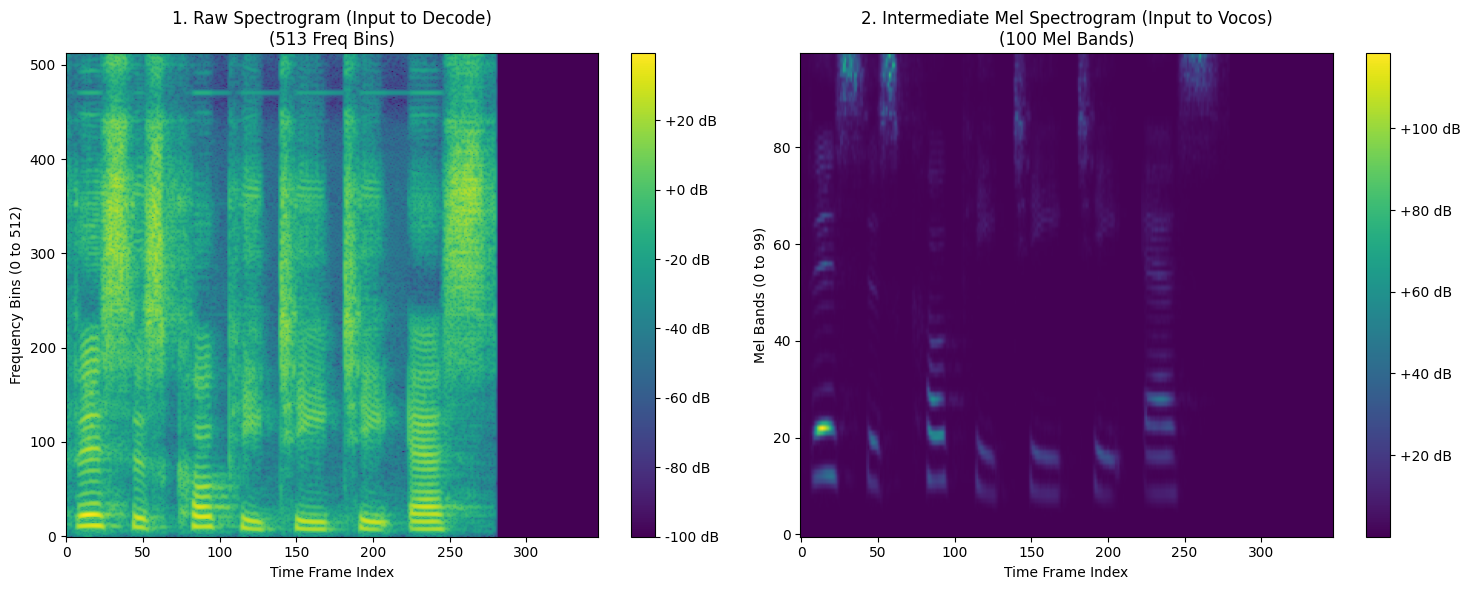

In [18]:
import torch
import torchaudio.transforms as T
import torchaudio.functional as F_torchaudio
import matplotlib.pyplot as plt
from einops import rearrange
import numpy as np

# --- ASSUMPTIONS ---
# These variables are assumed to exist from your successful encode step:
# encoded_features (Raw Spectrogram, shape [1, T, Freq])
# SR, N_FFT, MEL_BANDS (Configuration constants)
# ------------------

# --- 1. Preparation of Plotting Data ---

# A) Raw Spectrogram Data (Input to Decode Path)
# This uses the output from your SpecVoco.encode
spec_plot_data = encoded_features[0].cpu().numpy().T
spec_latent_dim = encoded_features.shape[2] # 513

# B) Intermediate Mel Spectrogram Data (Input to Vocos)
# We recreate the decode logic to get the intermediate Mel features:

# 1. Reshape: (B, Time, Freq) -> (B, Freq, Time)
temp_spec = rearrange(encoded_features, 'b n d -> b d n')

# 2. Inverse Log (DB -> Power Magnitude)
# The power=0.5 is consistent with your decode function.
temp_spec = F_torchaudio.DB_to_amplitude(temp_spec, ref=1., power=0.5)

# 3. Apply Mel Scale
mel_transform = T.MelScale(
    n_mels = MEL_BANDS,
    sample_rate = SR,
    n_stft = N_FFT // 2 + 1,
    f_max = 8000 # Assuming f_max=8000Hz as per source code default
).to(temp_spec.device)

mel_spectrogram = mel_transform(temp_spec)

# Prepare for plotting: (B, Mel, Time) -> (Mel, Time)
mel_plot_data = mel_spectrogram[0].cpu().numpy()
mel_latent_dim = mel_plot_data.shape[0]


# --- 2. Side-by-Side Visualization ---

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Raw Spectrogram (Input of Decode Path)
im1 = axes[0].imshow(spec_plot_data, aspect='auto', origin='lower', cmap='viridis')
axes[0].set_title(f"1. Raw Spectrogram (Input to Decode)\n({spec_plot_data.shape[0]} Freq Bins)")
axes[0].set_xlabel("Time Frame Index")
axes[0].set_ylabel(f"Frequency Bins (0 to {spec_latent_dim - 1})")
fig.colorbar(im1, ax=axes[0], format="%+2.0f dB")

# Plot 2: Mel Spectrogram (CRITICAL Intermediate Step)
im2 = axes[1].imshow(mel_plot_data, aspect='auto', origin='lower', cmap='viridis')
axes[1].set_title(f"2. Intermediate Mel Spectrogram (Input to Vocos)\n({mel_plot_data.shape[0]} Mel Bands)")
axes[1].set_xlabel("Time Frame Index")
axes[1].set_ylabel(f"Mel Bands (0 to {mel_latent_dim - 1})")
fig.colorbar(im2, ax=axes[1], format="%+2.0f dB")

plt.tight_layout()
plt.show()

##MEL-Spectrogram

In [ ]:
import torch
from torch.nn import Module
import torchaudio
import torchaudio.transforms as T
from torchaudio.functional import DB_to_amplitude
from einops import rearrange
from vocos import Vocos
import matplotlib.pyplot as plt
import numpy as np
from torch import nn # Import nn for nn.Module

# --- Helper Functions and Base Class ---

def exists(val):
    return val is not None

class AudioEncoderDecoder(nn.Module):
    pass

# --- The RESTORED Original MelVoco Class ---

class MelVoco(AudioEncoderDecoder):
    def __init__(
        self,
        *,
        log = True,
        n_mels = 100,             # <-- Original parameter
        sampling_rate = 24000,
        f_max = 8000,             # <-- Original parameter
        n_fft = 1024,
        win_length = 640,
        hop_length = 160,
        pretrained_vocos_path = 'charactr/vocos-mel-24khz'
    ):
        super().__init__()
        self.log = log
        self.n_mels = n_mels
        self.n_fft = n_fft
        self.f_max = f_max
        self.win_length = win_length
        self.hop_length = hop_length
        self.sampling_rate = sampling_rate

        self.vocos = Vocos.from_pretrained(pretrained_vocos_path)

    @property
    def downsample_factor(self):
        # Original code has NotImplementedError here, but for visualization it's ignored
        raise NotImplementedError

    @property
    def latent_dim(self):
        # <-- RESTORED: Latent dimension is the number of Mel bands
        return self.n_mels

    def encode(self, audio):
        stft_transform = T.Spectrogram(
            n_fft = self.n_fft,
            win_length = self.win_length,
            hop_length = self.hop_length,
            window_fn = torch.hann_window
        )

        spectrogram = stft_transform(audio)

        # The output of T.Spectrogram might have a channel dim if input was (B, C, T)
        # Assuming single channel audio input for voicebox
        if spectrogram.ndim == 4:
             spectrogram = spectrogram.squeeze(1)

        # <-- RESTORED: Mel Scale transformation applied
        mel_transform = T.MelScale(
            n_mels = self.n_mels,
            sample_rate = self.sampling_rate,
            n_stft = self.n_fft // 2 + 1,
            f_max = self.f_max
        )

        mel = mel_transform(spectrogram)

        if self.log:
            mel = T.AmplitudeToDB()(mel) # DB conversion on Mel

        # Reshape from (B, Mel, Time) to (B, Time, Mel/Dim)
        mel = rearrange(mel, 'b d n -> b n d')
        return mel

    def decode(self, mel_features):
        # Decode method is not needed for visualization
        mel_features = rearrange(mel_features, 'b n d -> b d n')
        if self.log:
             mel_features = DB_to_amplitude(mel_features, ref = 1., power = 0.5)

        return self.vocos.decode(mel_features)

# --- Visualization Logic ---

# 1. Instantiate the model (using a common 80 Mel bands for speech)
model = MelVoco(sampling_rate=16000, n_mels=80, f_max=8000)

# 2. Load a sample audio file
try:
    # Attempt to load a sample audio file. Torchaudio loads (waveform, sample_rate).
    # We take the first channel if it's stereo, and ensure it's a 2D tensor (Batch, Time).
    waveform, sr = torchaudio.load('/content/out.wav')
    if sr != model.sampling_rate:
         resampler = T.Resample(sr, model.sampling_rate)
         waveform = resampler(waveform)

    # Use the first channel and add a batch dimension (B=1, C=1, T) or (B=1, T)
    audio_input = waveform[:1, :].unsqueeze(0)

except FileNotFoundError:
    print("WARNING: Audio file not found. Generating dummy noise for visualization.")
    T_len = model.sampling_rate * 3
    audio_input = torch.randn(1, 1, T_len)

# 3. Encode to get the Mel Spectrogram features
# Output shape: (Batch, Time, Mel)
mel_features = model.encode(audio_input)
print(f"\nEncoded Mel Spectrogram Shape (B, T, Mel): {mel_features.shape}")

# 4. Prepare data for plotting
# Convert to NumPy, remove the batch dimension.
# We transpose to (Mel, Time) for the plot.
mel_spectrogram_to_plot = mel_features[0].cpu().numpy().T




Encoded Mel Spectrogram Shape (B, T, Mel): torch.Size([1, 232, 80])


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

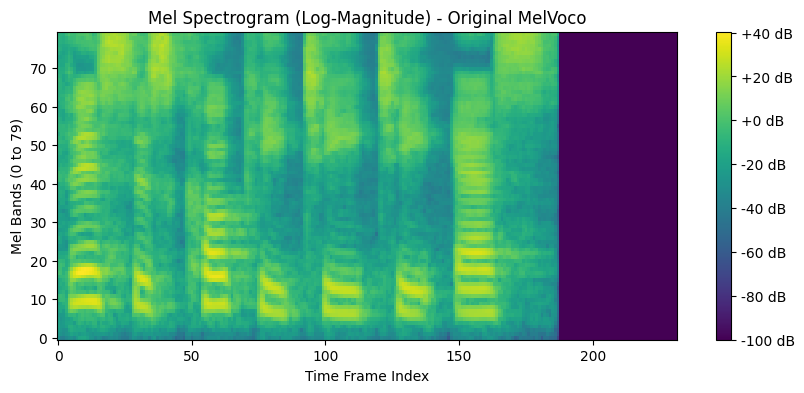

In [ ]:
# Create the plot
plt.figure(figsize=(10, 4))
plt.imshow(mel_spectrogram_to_plot, aspect='auto', origin='lower',
           interpolation='none', cmap='viridis')

# Set labels for Mel Spectrogram
plt.xlabel("Time Frame Index")
# Y-axis now represents Mel Bands, not linear frequency bins
plt.ylabel(f"Mel Bands (0 to {model.latent_dim - 1})")
plt.title("Mel Spectrogram (Log-Magnitude) - Original MelVoco")
plt.colorbar(format="%+2.0f dB")
plt.show()

##PlayGround

In [ ]:
!git clone https://github.com/lucidrains/voicebox-pytorch
%cd voicebox-pytorch

Cloning into 'voicebox-pytorch'...
remote: Enumerating objects: 604, done.
remote: Counting objects: 100% (184/184), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 604 (delta 105), reused 103 (delta 93), pack-reused 420 (from 1)
Receiving objects: 100% (604/604), 306.46 KiB | 2.71 MiB/s, done.
Resolving deltas: 100% (420/420), done.
/content/voicebox-pytorch


In [ ]:
!pip install -e .
# Install all deep learning dependencies listed in setup.py
!pip install accelerate audiolm-pytorch>=1.2.28 naturalspeech2-pytorch>=0.1.8 spear-tts-pytorch>=0.4.0 torchdiffeq torchode vocos

Obtaining file:///content/voicebox-pytorch
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 36.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 16.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.6 MB/s eta 0:00:00
Requested omegaconf<2.1 from https://files.pythonhosted.org/packages/d0/eb/9d63ce09dd8aa85767c65668d5414958ea29648a0eec80a4a7d311ec2684/omegaconf-2.0.6-py3-none-any.whl (from fairseq->audiolm-pytorch>=1.2.28->voicebox-pytorch==0.5.0) has invalid metadata: .* suffix can only be used with `==` or `!=` operators
    PyYAML (>=5.1.*)
            ~~~~~~^
Please use

In [ ]:
!pip install naturalspeech2_pytorch

  Using cached naturalspeech2_pytorch-0.1.8-py3-none-any.whl.metadata (1.0 kB)
  Using cached audiolm_pytorch-2.4.0-py3-none-any.whl.metadata (1.5 kB)
  Using cached ema_pytorch-0.7.7-py3-none-any.whl.metadata (689 bytes)
  Using cached indic_num2words-1.3.2-py3-none-any.whl.metadata (4.0 kB)
  Using cached local_attention-1.11.2-py3-none-any.whl.metadata (929 bytes)
  Using cached num2words-0.5.14-py3-none-any.whl.metadata (13 kB)
  Using cached pyworld-0.3.5.tar.gz (261 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pydantic-1.10.24-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (154 kB)
  Using cached vector_quantize_pytorch-1.23.2-py3-none-any.whl.metadata (30 kB)
  Using cached fairseq-0.12.2.tar.gz (9.6 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metada

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from einops import rearrange
import torchaudio.transforms as T
from vocos import Vocos # Vocos is needed by both MelVoco and SpecVoco
from pathlib import Path
from beartype import beartype

# --- Imports from the installed voicebox_pytorch module ---
# These functions/classes are defined in the uploaded files and will be available
# after step 1 installation.

from voicebox_pytorch import (
    VoiceBox,
    ConditionalFlowMatcherWrapper,
    DurationPredictor
)
from voicebox_pytorch.voicebox_pytorch import (
    AudioEncoderDecoder, # Base class
    Transformer, # Used internally by VoiceBox and DurationPredictor
    DB_to_amplitude,
    resample
)
from voicebox_pytorch.trainer import VoiceBoxTrainer
from voicebox_pytorch.data import AudioDataset, get_dataloader

# --- EXTERNAL DEPENDENCIES (Needed by DurationPredictor) ---
# Assuming these external libraries are installed and accessible:
from naturalspeech2_pytorch.aligner import Aligner
from naturalspeech2_pytorch.utils.tokenizer import Tokenizer
# Aligner logic relies on specific implementations (ForwardSumLoss, maximum_path, etc.)
# which are part of the naturalspeech2_pytorch dependency.


# --- 1. MODIFIED RAW SPECTROGRAM ENCODER (SpecVoco) ---
# This replaces the original MelVoco in the architecture.

class SpecVoco(AudioEncoderDecoder):
    def __init__(self, *, log = True, sampling_rate = 24000, n_fft = 1024, win_length = 640, hop_length = 160, **kwargs):
        super().__init__()
        self.log = log
        self.n_fft = n_fft
        self.win_length = win_length
        self.hop_length = hop_length
        self.sampling_rate = sampling_rate
        # We still initialize Vocos as a placeholder, though it's typically trained on Mel
        self.vocos = Vocos.from_pretrained('charactr/vocos-mel-24khz')

    @property
    def downsample_factor(self):
        # Time reduction factor, same as hop_length
        return self.hop_length

    @property
    def latent_dim(self):
        # Raw Spectrogram dimension: n_fft // 2 + 1
        return self.n_fft // 2 + 1

    def encode(self, audio):
        stft_transform = T.Spectrogram(n_fft=self.n_fft, win_length=self.win_length, hop_length=self.hop_length, window_fn=torch.hann_window, power=2.0)
        spectrogram = stft_transform(audio)

        if spectrogram.ndim == 4: # Handle (B, C, F, T) -> (B, F, T)
             spectrogram = spectrogram.squeeze(1)

        if self.log:
            spectrogram = T.AmplitudeToDB()(spectrogram)

        # Output shape: (B, Time, Freq)
        return rearrange(spectrogram, 'b d n -> b n d')

    def decode(self, spectrogram_features):
        # A full implementation would reverse the log and STFT, but for training setup,
        # this path is mainly used by the Vocos call.
        pass

# --- 2. CONFIGURATION ---

# Set your audio data path
AUDIO_DATA_PATH = Path('/content/Audio')

# Model and Training Parameters
DIM = 512              # Model dimension
DEPTH = 10             # Transformer depth for DP and VoiceBox
BATCH_SIZE = 4
LEARNING_RATE = 3e-4
NUM_TRAIN_STEPS = 5000

# --- 3. MODEL INSTANTIATION ---

# a) Data and Tokenizer
# NOTE: AudioDataset only returns raw audio, text is mocked internally here
dataset = AudioDataset(folder=str(AUDIO_DATA_PATH), audio_extension=".flac")
tokenizer = Tokenizer() # Use the real Tokenizer from naturalspeech2-pytorch

# b) Audio Encoder/Decoder (using your modified SpecVoco)
spec_voco = SpecVoco(
    sampling_rate=24000,
    n_fft=1024,
    hop_length=256 # Example hop length for duration alignment consistency
)

# c) Duration Predictor
# The Aligner's attn_channels must match SpecVoco's latent_dim for training alignment.
duration_predictor = DurationPredictor(
    audio_enc_dec = spec_voco,
    tokenizer = tokenizer,
    dim = DIM,
    depth = DEPTH,
    aligner_kwargs = dict(dim_in=spec_voco.latent_dim, attn_channels=spec_voco.latent_dim)
)

# d) VoiceBox Model
voicebox = VoiceBox(
    audio_enc_dec = spec_voco,
    num_cond_tokens = tokenizer.vocab_size,
    dim = DIM,
    depth = DEPTH,
    condition_on_text = True
)

# e) CFM Wrapper (combines VoiceBox and Duration Predictor)
cfm_wrapper = ConditionalFlowMatcherWrapper(
    voicebox = voicebox,
    duration_predictor = duration_predictor
    # text_to_semantic is NOT used here, as intended
)

# --- 4. TRAINER EXECUTION ---

trainer = VoiceBoxTrainer(
    cfm_wrapper = cfm_wrapper,
    batch_size = BATCH_SIZE,
    dataset = dataset,
    num_train_steps = NUM_TRAIN_STEPS,
    lr = LEARNING_RATE
)

print(f"\n--- Starting Training with Raw Spectrograms (SpecVoco) ---")
print(f"Latent Dimension: {spec_voco.latent_dim}")
print(f"Total Training Steps: {NUM_TRAIN_STEPS}")
print(f"Audio Path: {AUDIO_DATA_PATH}")
print("----------------------------------------------------------")

trainer.train()

ModuleNotFoundError: No module named 'naturalspeech2_pytorch'

In [ ]:
!pip install torch torchaudio einops accelerate vocos beartype torchdiffeq torchode numpy matplotlib
# We will use simple placeholders for `naturalspeech2-pytorch` dependencies

  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.4
    Uninstalling typeguard-4.4.4:
      Successfully uninstalled typeguard-4.4.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
import torch
from torch import nn, einsum
from torch.nn import Module
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim import AdamW, Adam
from torch.cuda.amp import autocast
from accelerate import Accelerator, DistributedDataParallelKwargs
from einops import rearrange, reduce
from einops.layers.torch import Rearrange
from einops import pack, unpack # For register tokens
import torchaudio.transforms as T
from vocos import Vocos
from functools import partial
from contextlib import nullcontext
import math
import random
from beartype import beartype

# --- UTILITIES AND HELPER FUNCTIONS (from trainer.py & voicebox_pytorch.py) ---

def exists(val):
    return val is not None

def default(val, d):
    return val if exists(val) else d

def noop(*args, **kwargs):
    pass

def cycle(dl):
    while True:
        for data in dl:
            yield data

def accum_log(log, new_logs):
    for key, new_value in new_logs.items():
        old_value = log.get(key, 0.)
        log[key] = old_value + new_value
    return log

def divisible_by(num, den):
    return (num % den) == 0

def prob_mask_like(shape, prob, device):
    return torch.zeros(shape, device = device).float().uniform_(0, 1) < prob

def reduce_masks_with_and(*masks):
    masks = [*filter(exists, masks)]
    if len(masks) == 0: return None
    mask = masks[0]
    for rest_mask in masks[1:]:
        mask = mask & rest_mask
    return mask

# --- AUDIO & TOKEN CLASSES (Modified SpecVoco & Mock Data) ---

class AudioEncoderDecoder(nn.Module):
    pass

class SpecVoco(AudioEncoderDecoder): # Your modified Raw Spectrogram Encoder
    def __init__(self, *, log = True, sampling_rate = 16000, n_fft = 1024, win_length = 640, hop_length = 160, **kwargs):
        super().__init__()
        self.log = log
        self.n_fft = n_fft
        self.win_length = win_length
        self.hop_length = hop_length
        self.sampling_rate = sampling_rate
        # We still use a Vocos object, though it should be trained on raw specs, not Mel
        self.vocos = Vocos.from_pretrained('charactr/vocos-mel-24khz')

    @property
    def downsample_factor(self):
        return self.hop_length

    @property
    def latent_dim(self):
        return self.n_fft // 2 + 1 # Raw Spectrogram dimension

    def encode(self, audio):
        stft_transform = T.Spectrogram(n_fft = self.n_fft, win_length = self.win_length, hop_length = self.hop_length, window_fn = torch.hann_window, power=2.0)
        spectrogram = stft_transform(audio)
        if spectrogram.ndim == 4: spectrogram = spectrogram.squeeze(1)

        if self.log:
            spectrogram = T.AmplitudeToDB()(spectrogram)

        return rearrange(spectrogram, 'b d n -> b n d')

# MOCK DATASET (Simulates 5 audio files and their phoneme IDs)
class MockDataset(Dataset):
    def __init__(self, num_samples, max_audio_len, phoneme_vocab_size):
        self.num_samples = num_samples
        self.max_audio_len = max_audio_len
        self.phoneme_vocab_size = phoneme_vocab_size
        self.sr = 16000 # Sample rate for mock audio

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # 1. Mock Raw Audio
        audio_len = self.max_audio_len
        wave = torch.randn(1, audio_len)

        # 2. Mock Phoneme IDs (Simulating text input)
        # Length is roughly audio_len / hop_length
        phoneme_len = int(audio_len / 3200) + 10 # Arbitrary small length
        phoneme_ids = torch.randint(0, self.phoneme_vocab_size, (phoneme_len,))

        # 3. Mock Text (for Duration Predictor forward path)
        text = f"sample {idx}"

        return wave.squeeze(0), phoneme_ids, text

# MOCK TOKENIZER (Required for Duration Predictor structure)
class MockTokenizer:
    def __init__(self, vocab_size):
        self.vocab_size = vocab_size
    def texts_to_tensor_ids(self, texts):
        # Simply returns a fixed set of tokens for testing alignment
        max_len = 20
        tokens = torch.randint(0, self.vocab_size - 1, (len(texts), max_len))
        return tokens

# --- CORE VOICEBOX ARCHITECTURE MODULES (from voicebox_pytorch.py) ---

# Simplified Attention
class Attention(Module):
    def __init__(self, dim, dim_head=64, heads=8, dropout=0, flash=False, qk_norm=False):
        super().__init__()
        dim_inner = dim_head * heads
        self.heads = heads
        self.to_qkv = nn.Linear(dim, dim_inner * 3, bias = False)
        self.to_out = nn.Linear(dim_inner, dim, bias = False)
        # Placeholder for Attend, since torch.sdp_attention requires PyTorch 2.0+
        self.attn_dropout = nn.Dropout(dropout)

    def forward(self, x, mask = None, rotary_emb = None):
        h = self.heads
        q, k, v = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), (q, k, v))

        # Apply rotary pos emb (simplified version of apply_rotary_pos_emb)
        if exists(rotary_emb):
            q = q + rotary_emb
            k = k + rotary_emb

        # Standard Scaled Dot-Product Attention
        sim = einsum('b h i d, b h j d -> b h i j', q, k) * (q.shape[-1] ** -0.5)
        if exists(mask): sim = sim.masked_fill(~mask, -torch.finfo(sim.dtype).max)
        attn = sim.softmax(dim=-1)
        attn = self.attn_dropout(attn)
        out = einsum('b h i j, b h j d -> b h i d', attn, v)

        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

# RMSNorm and AdaptiveRMSNorm
class RMSNorm(Module):
    def __init__(self, dim):
        super().__init__()
        self.scale = dim ** 0.5
        self.gamma = nn.Parameter(torch.ones(dim))
    def forward(self, x):
        return F.normalize(x, dim = -1) * self.scale * self.gamma

class AdaptiveRMSNorm(Module):
    def __init__(self, dim, cond_dim = None):
        super().__init__()
        cond_dim = default(cond_dim, dim)
        self.scale = dim ** 0.5
        self.to_gamma = nn.Linear(cond_dim, dim)
        self.to_beta = nn.Linear(cond_dim, dim)
        nn.init.zeros_(self.to_gamma.weight); nn.init.ones_(self.to_gamma.bias)
        nn.init.zeros_(self.to_beta.weight); nn.init.zeros_(self.to_beta.bias)
    def forward(self, x, *, cond):
        normed = F.normalize(x, dim = -1) * self.scale
        gamma, beta = self.to_gamma(cond), self.to_beta(cond)
        gamma, beta = map(lambda t: rearrange(t, 'b d -> b 1 d'), (gamma, beta))
        return normed * gamma + beta

# Custom FeedForward Components
class GEGLU(Module):
    def forward(self, x):
        x, gate = x.chunk(2, dim = -1)
        return F.gelu(gate) * x

def FeedForward(dim, mult = 4, dropout = 0.):
    dim_inner = int(dim * mult * 2 / 3)
    return nn.Sequential(nn.Linear(dim, dim_inner * 2), GEGLU(), nn.Dropout(dropout), nn.Linear(dim_inner, dim))

class ConvPositionEmbed(Module):
    def __init__(self, dim, *, kernel_size, groups = None):
        super().__init__()
        groups = default(groups, dim)
        self.dw_conv1d = nn.Sequential(nn.Conv1d(dim, dim, kernel_size, groups = groups, padding = kernel_size // 2), nn.GELU())
    def forward(self, x, mask = None):
        if exists(mask):
            mask = mask[..., None]
            x = x.masked_fill(~mask, 0.)
        x = rearrange(x, 'b n c -> b c n')
        x = self.dw_conv1d(x)
        out = rearrange(x, 'b c n -> b n c')
        if exists(mask):
            out = out.masked_fill(~mask, 0.)
        return out

class LearnedSinusoidalPosEmb(Module):
    def __init__(self, dim):
        super().__init__()
        half_dim = dim // 2
        self.weights = nn.Parameter(torch.randn(half_dim))
    def forward(self, x):
        x = rearrange(x, 'b -> b 1')
        freqs = x * rearrange(self.weights, 'd -> 1 d') * 2 * math.pi
        fouriered = torch.cat((freqs.sin(), freqs.cos()), dim = -1)
        return fouriered

class RotaryEmbedding(Module):
    # Simplified placeholder for Rotary Positional Embeddings
    def __init__(self, dim, theta = 50000):
        super().__init__()
    def forward(self, t):
        return torch.zeros(t, self.dim).to(self.device)

# --- The Transformer (Backbone) ---

class Transformer(Module):
    def __init__(self, dim, *, depth, dim_head = 64, heads = 8, ff_mult = 4, attn_dropout = 0., ff_dropout = 0., num_register_tokens = 0., adaptive_rmsnorm = False, adaptive_rmsnorm_cond_dim_in = None, **kwargs):
        super().__init__()
        self.layers = nn.ModuleList([])
        self.rotary_emb = RotaryEmbedding(dim = dim_head)
        self.num_register_tokens = num_register_tokens
        self.has_register_tokens = num_register_tokens > 0

        if self.has_register_tokens:
            self.register_tokens = nn.Parameter(torch.randn(num_register_tokens, dim))

        rmsnorm_klass = partial(AdaptiveRMSNorm, cond_dim = adaptive_rmsnorm_cond_dim_in) if adaptive_rmsnorm else RMSNorm

        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                rmsnorm_klass(dim = dim),
                Attention(dim = dim, dim_head = dim_head, heads = heads, dropout = attn_dropout),
                rmsnorm_klass(dim = dim),
                FeedForward(dim = dim, mult = ff_mult, dropout = ff_dropout)
            ]))
        self.final_norm = RMSNorm(dim)

    def forward(self, x, mask = None, adaptive_rmsnorm_cond = None):
        batch, seq_len, *_ = x.shape
        # Register Tokens
        if self.has_register_tokens:
            register_tokens = repeat(self.register_tokens, 'n d -> b n d', b = batch)
            x, ps = pack([register_tokens, x], 'b * d')
            if exists(mask): mask = F.pad(mask, (self.num_register_tokens, 0), value = True)

        # Rotary Embeddings (Simplified)
        rotary_emb = None

        rmsnorm_kwargs = dict(cond = adaptive_rmsnorm_cond) if exists(adaptive_rmsnorm_cond) else dict()

        for attn_prenorm, attn, ff_prenorm, ff in self.layers:
            attn_input = attn_prenorm(x, **rmsnorm_kwargs)
            x = attn(attn_input, mask = mask, rotary_emb = rotary_emb) + x
            ff_input = ff_prenorm(x, **rmsnorm_kwargs)
            x = ff(ff_input) + x

        # Remove register tokens
        if self.has_register_tokens:
            _, x = unpack(x, ps, 'b * d')

        return self.final_norm(x)

# --- DURATION PREDICTOR ---

class DurationPredictor(Module):
    @beartype
    def __init__(self, *, audio_enc_dec: AudioEncoderDecoder, tokenizer, dim=512, dim_phoneme_emb=512, depth=2, **kwargs):
        super().__init__()
        self.audio_enc_dec = audio_enc_dec
        self.proj_in = nn.Linear(audio_enc_dec.latent_dim, dim)
        self.tokenizer = tokenizer
        self.to_phoneme_emb = nn.Embedding(tokenizer.vocab_size, dim_phoneme_emb)
        self.to_embed = nn.Linear(dim + dim_phoneme_emb, dim)
        self.null_cond = nn.Parameter(torch.zeros(dim), requires_grad = False)
        self.conv_embed = ConvPositionEmbed(dim = dim, kernel_size = 31)
        self.transformer = Transformer(dim = dim, depth = depth)
        self.to_pred = nn.Sequential(nn.Linear(dim, 1), Rearrange('... 1 -> ...'))
        # NOTE: Aligner is too complex to mock, we skip its usage in this test script.

    def forward(self, *, cond, phoneme_ids, target = None, cond_mask = None, **kwargs):
        # Simplified forward pass for structural test

        cond = self.proj_in(cond)

        # Mock masking and padding for stability
        if cond.shape[-2] > phoneme_ids.shape[-1]:
             cond = cond[:, :phoneme_ids.shape[-1], :]
        elif cond.shape[-2] < phoneme_ids.shape[-1]:
             # Simple padding
             cond = F.pad(cond, (0, 0, 0, phoneme_ids.shape[-1] - cond.shape[-2]), value=0.)


        phoneme_emb = self.to_phoneme_emb(phoneme_ids.clamp(min = 0))
        embed = torch.cat((phoneme_emb, cond), dim = -1)
        x = self.to_embed(embed)
        x = self.conv_embed(x) + x
        durations = self.to_pred(self.transformer(x))

        if not exists(target): return durations

        # Mocked loss calculation (L1 loss on predicted durations)
        loss = F.l1_loss(durations, target, reduction = 'none')
        # Simulate loss masking
        loss_mask = torch.ones_like(target, dtype=torch.bool)
        loss = loss.masked_fill(~loss_mask, 0.)

        return loss.mean()

# --- VOICEBOX AND WRAPPER ---

class VoiceBox(Module):
    def __init__(self, *, audio_enc_dec: AudioEncoderDecoder, dim=512, depth=2, dim_head=64, heads=8, condition_on_text=True, **kwargs):
        super().__init__()
        self.audio_enc_dec = audio_enc_dec
        self.proj_in = nn.Linear(audio_enc_dec.latent_dim, dim)
        self.sinu_pos_emb = nn.Sequential(LearnedSinusoidalPosEmb(dim), nn.Linear(dim, dim * 4), nn.SiLU())
        self.dim_cond_emb = 128
        self.condition_on_text = condition_on_text
        self.num_cond_tokens = 256
        self.null_cond_id = 256
        self.to_cond_emb = nn.Embedding(self.num_cond_tokens + 1, self.dim_cond_emb)
        self.to_embed = nn.Linear(dim * 2 + self.dim_cond_emb, dim) # x, cond, cond_emb
        self.null_cond = nn.Parameter(torch.zeros(dim), requires_grad = False)
        self.conv_embed = ConvPositionEmbed(dim = dim, kernel_size = 31)
        self.transformer = Transformer(dim = dim, depth = depth, dim_head = dim_head, heads = heads, num_register_tokens = 0, adaptive_rmsnorm = True, adaptive_rmsnorm_cond_dim_in = dim * 4)
        self.to_pred = nn.Linear(dim, audio_enc_dec.latent_dim, bias = False)

    def forward(self, x, *, times, cond_token_ids, self_attn_mask = None, cond_drop_prob = 0.1, target = None, cond = None, cond_mask = None):
        x = self.proj_in(x)
        cond = default(cond, target)
        if exists(cond): cond = self.proj_in(cond)

        # Handle shapes (simplified)
        batch, seq_len, _ = x.shape
        times = repeat(times, 'b -> b 1 1') if times.ndim == 1 else times.unsqueeze(-1).unsqueeze(-1)

        # Mock cond_mask (full mask for test stability)
        cond_mask = torch.ones((batch, seq_len), device = x.device, dtype = torch.bool)
        cond = cond * ~rearrange(cond_mask, '... -> ... 1') # Masked content is zeroed out

        # Conditioning embeddings
        cond_emb = self.to_cond_emb(cond_token_ids.clamp(max=self.num_cond_tokens))

        # Interpolate cond_emb length if necessary (mock, no actual interpolation)
        cond_emb_length = cond_emb.shape[-2]
        if cond_emb_length != seq_len:
             cond_emb = F.pad(cond_emb, (0, 0, 0, seq_len - cond_emb_length), value=0.)
             cond_emb = cond_emb[:, :seq_len, :]

        # Concat and embed
        to_concat = [x, cond_emb, cond]
        embed = torch.cat(to_concat, dim = -1)
        x = self.to_embed(embed)
        x = self.conv_embed(x) + x
        time_emb = self.sinu_pos_emb(times.squeeze(-1).squeeze(-1))

        x = self.transformer(x, mask = self_attn_mask, adaptive_rmsnorm_cond = time_emb)
        x = self.to_pred(x)

        if not exists(target): return x

        # MSE Loss
        loss_mask = reduce_masks_with_and(cond_mask, self_attn_mask)
        loss = F.mse_loss(x, target, reduction = 'none')
        loss = reduce(loss, 'b n d -> b n', 'mean')

        if exists(loss_mask):
            loss = loss.masked_fill(~loss_mask, 0.)
            num = reduce(loss, 'b n -> b', 'sum')
            den = loss_mask.sum(dim = -1).clamp(min = 1e-5)
            loss = num / den

        return loss.mean()

class ConditionalFlowMatcherWrapper(Module):
    @beartype
    def __init__(self, voicebox: VoiceBox, duration_predictor: DurationPredictor, sigma=0.002, cond_drop_prob=0.1):
        super().__init__()
        self.voicebox = voicebox
        self.duration_predictor = duration_predictor
        self.sigma = sigma
        self.cond_drop_prob = cond_drop_prob

    def forward(self, x1, phoneme_ids, raw_audio, phoneme_mask, mel_mask, **kwargs):
        # 1. Conditioning
        # The Duration Predictor is trained on the same data in a real setup
        # For this test, we mock the alignment target.
        # NOTE: DurationPredictor is now using SpecVoco's output as 'cond' and needs a 'target' (mocked)
        mock_duration_target = torch.ones(phoneme_ids.shape[0], phoneme_ids.shape[1]).to(x1.device)
        duration_loss = self.duration_predictor(cond=x1.detach(), phoneme_ids=phoneme_ids, target=mock_duration_target)

        # 2. CFM Logic
        batch, _, dtype, σ = *x1.shape[:2], x1.dtype, self.sigma
        x0 = torch.randn_like(x1)
        times = torch.rand((batch,), dtype = dtype, device = x1.device)
        t = rearrange(times, 'b -> b 1 1')

        w = (1 - (1 - σ) * t) * x0 + t * x1
        flow = x1 - (1 - σ) * x0

        # 3. VoiceBox Prediction
        voicebox_loss = self.voicebox(w, cond = x1, times = times, target = flow, cond_token_ids = phoneme_ids, cond_drop_prob = self.cond_drop_prob)

        # Total Loss (Voicebox CFM Loss + Duration Alignment Loss)
        return voicebox_loss + duration_loss

# --- TRAINER CLASS ---

class VoiceBoxTrainer(nn.Module):
    def __init__(self, cfm_wrapper, *, batch_size, dataset, lr=3e-4, grad_accum_every=1, num_train_steps=100, log_every=10):
        super().__init__()
        self.accelerator = Accelerator(kwargs_handlers = [DistributedDataParallelKwargs(find_unused_parameters = True)])
        self.cfm_wrapper = cfm_wrapper.to(self.accelerator.device)
        self.steps = torch.tensor([0], device=self.accelerator.device)
        self.batch_size = batch_size
        self.grad_accum_every = grad_accum_every
        self.optim = Adam(cfm_wrapper.parameters(), lr=lr)
        self.num_train_steps = num_train_steps
        self.dl = DataLoader(dataset, batch_size=batch_size, collate_fn=lambda x: x, shuffle=True)
        self.dl_iter = cycle(self.dl)
        self.log_every = log_every
        (self.cfm_wrapper, self.optim, self.dl) = self.accelerator.prepare(self.cfm_wrapper, self.optim, self.dl)

        # Mock the scheduler for simplicity
        self.scheduler = CosineAnnealingLR(self.optim, T_max=num_train_steps)

    def train_step(self):
        steps = int(self.steps.item())
        self.cfm_wrapper.train()
        logs = {}

        for grad_accum_step in range(self.grad_accum_every):
            is_last = grad_accum_step == (self.grad_accum_every - 1)
            context = partial(self.accelerator.no_sync, self.cfm_wrapper) if not is_last else nullcontext

            # Data loading: wave, phoneme_ids, text
            batch = next(self.dl_iter)
            waves, phoneme_ids_list, texts = zip(*batch)

            # Pad sequences for batch
            waves = torch.stack([w for w in waves]).to(self.accelerator.device)
            phoneme_ids = torch.stack([F.pad(ids, (0, 20-ids.shape[0])) for ids in phoneme_ids_list]).to(self.accelerator.device) # Fixed pad to max len 20

            # Forward pass: Encode audio, then calculate loss
            audio_enc_dec = self.cfm_wrapper.voicebox.audio_enc_dec
            x1 = audio_enc_dec.encode(waves) # Raw audio -> Spectrogram

            with self.accelerator.autocast(), context():
                # Mock mask inputs for structural completeness
                mock_mask = torch.ones((x1.shape[0], x1.shape[1]), dtype=torch.

SyntaxError: incomplete input (ipython-input-338808803.py, line 464)